In [8]:
!pip install trino pandas scikit-learn apscheduler matplotlib seaborn


In [9]:
import trino
from trino.auth import BasicAuthentication
import pandas as pd

# Define connection parameters for Trino
trino_host = '18.188.112.55'
trino_port = 8080

# Trino connection function
def connect_trino():
    return trino.dbapi.connect(
        host=trino_host,
        port=trino_port,
        user="admin"
    )


In [106]:
# Function to query Trino and process data for anomaly detection
def query_trino_for_anomalies():
    conn = connect_trino()

    # Define date range
    start_date = '2024-11-1'
    end_date = '2024-11-13'

    # Query logs and metrics data
    query_logs = f"""
    SELECT * FROM iceberg.apm_logs.logs
    WHERE createdTime >= DATE '{start_date}' AND createdTime < DATE '{end_date}'
    """
    query_metrics = f"""
    SELECT * FROM iceberg.apm_metrics.metrics
    WHERE createdTime >= DATE '{start_date}' AND createdTime < DATE '{end_date}'
    """

    # Load data into DataFrames
    logs_df = pd.read_sql(query_logs, conn)
    metrics_df = pd.read_sql(query_metrics, conn)

    # Convert time columns to datetime
    logs_df['createdtime'] = pd.to_datetime(logs_df['createdtime'])
    metrics_df['createdtime'] = pd.to_datetime(metrics_df['createdtime'])

    return logs_df, metrics_df
logs_df, metrics_df = query_trino_for_anomalies()


<ipython-input-106-86e0157d8deb>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  logs_df = pd.read_sql(query_logs, conn)
<ipython-input-106-86e0157d8deb>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  metrics_df = pd.read_sql(query_metrics, conn)


In [107]:
print(logs_df.columns)  # To check the available columns


Index(['servicename', 'language', 'scopename', 'traceid', 'spanid',
       'timeunixnano', 'observedtimeunixnano', 'createdtime', 'severitytext',
       'severitynumber', 'body', 'attributes'],
      dtype='object')


In [108]:
print(metrics_df.columns)

Index(['servicename', 'createdtime', 'cpuusage', 'memoryusage'], dtype='object')


In [118]:
# Call the function to get data
logs_df, metrics_df = query_trino_for_anomalies()

# Map severity to numeric levels for logs
log_levels = {'INFO': 0, 'WARNING': 1, 'ERROR': 2}
logs_df['severity_numeric'] = logs_df['severitytext'].map(log_levels)

# Convert 'createdtime' to datetime format
logs_df['createdtime'] = pd.to_datetime(logs_df['createdtime'])

# Define a column for 'error_count' by counting "ERROR" entries in each interval
logs_df['error_flag'] = logs_df['severitytext'].apply(lambda x: 1 if x == 'ERROR' else 0)

# Set 'createdtime' as the index
logs_df = logs_df.set_index('createdtime')

# Ensure the index is datetime
if not isinstance(logs_df.index, pd.DatetimeIndex):
    print("Error: 'createdtime' is not a DatetimeIndex. Please check the input data.")
else:
    # Aggregating logs features with a 60-minute frequency
    logs_features = logs_df.resample('60Min').agg({
        'error_flag': 'sum'  # Sum of errors within the interval as 'error_count'
    }).rename(columns={'error_flag': 'error_count'}).fillna(0)

# Print the aggregated log features DataFrame to verify results
print(logs_features)

# Aggregating metrics features
metrics_df['createdtime'] = pd.to_datetime(metrics_df['createdtime'])  # Ensure datetime format
metrics_df.set_index('createdtime', inplace=True)
numeric_metrics = metrics_df[['cpuusage', 'memoryusage']]
metrics_features = numeric_metrics.resample('120Min').mean().fillna(0)

# Print the aggregated metrics features DataFrame to verify results
print(metrics_features)

# Combine logs and metrics data
combined_df = logs_features.join(metrics_features, how='outer').fillna(0)
# Ensure 'createdtime' is included as a column but still part of the index
combined_df.reset_index(inplace=True)

# Ensure 'anomaly_score' is included as a column but still part of the index
# combined_df.reset_index(inplace=True)

# Display combined data
print(combined_df.columns)
print(combined_df)
print(combined_df.head())


<ipython-input-106-86e0157d8deb>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  logs_df = pd.read_sql(query_logs, conn)
<ipython-input-106-86e0157d8deb>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  metrics_df = pd.read_sql(query_metrics, conn)


                     error_count
createdtime                     
2024-11-05 12:00:00           39
2024-11-05 13:00:00            0
2024-11-05 14:00:00            0
2024-11-05 15:00:00            0
2024-11-05 16:00:00            0
...                          ...
2024-11-08 00:00:00            0
2024-11-08 01:00:00            0
2024-11-08 02:00:00            0
2024-11-08 03:00:00            1
2024-11-08 04:00:00            0

[65 rows x 1 columns]
                     cpuusage   memoryusage
createdtime                                
2024-11-05 10:00:00  0.000078  4.181102e+11
2024-11-05 12:00:00  0.000297  3.856004e+11
2024-11-05 14:00:00  0.000172  4.156406e+11
2024-11-05 16:00:00  0.000164  4.090646e+11
2024-11-05 18:00:00  0.000149  3.263785e+11
2024-11-05 20:00:00  0.000157  3.750005e+11
2024-11-05 22:00:00  0.000160  4.226052e+11
2024-11-06 00:00:00  0.000166  4.622030e+11
2024-11-06 02:00:00  0.000147  3.858701e+11
2024-11-06 04:00:00  0.000148  3.893267e+11
2024-11-06 06:00:00 

In [119]:
print(combined_df.columns)

Index(['createdtime', 'error_count', 'cpuusage', 'memoryusage'], dtype='object')


In [123]:
from sklearn.ensemble import IsolationForest

# Define solution suggestion function
def suggest_solution(row):
    solutions = []
    if row['cpuusage'] > 60:
        solutions.append("High CPU usage: Consider scaling resources or optimizing code")
    if row['memoryusage'] > 1.5:
        solutions.append("High memory usage: Review applications consuming excessive memory or consider increasing memory capacity")
    if row['error_count'] < 100:
        solutions.append("High error count: Investigate frequent error sources and check for redundant or high-frequency logging.")
    if row['createdtime'].hour > 10:
        solutions.append("High latency: Optimize response times and check server performance and load balancing.")
    return "; ".join(solutions) if solutions else "No immediate solution."

# Convert 'createdtime' to a numerical value (e.g., timestamp in seconds) if you want to use it for anomaly detection
combined_df['timestamp'] = combined_df['createdtime'].astype(int) / 10**9  # Convert to seconds since epoch

# Perform anomaly detection
features_for_anomaly = combined_df[['timestamp', 'memoryusage', 'cpuusage',  'error_count']]
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
combined_df['anomaly_score'] = model.fit_predict(features_for_anomaly)

# Apply solution suggestions
combined_df['solution'] = combined_df.apply(suggest_solution, axis=1)

# Display anomalies and solutions
print("Detected Anomalies and Suggested Solutions:\n")
print(combined_df[combined_df['anomaly_score'] == -1][['createdtime','cpuusage','memoryusage',  'error_count',  'anomaly_score', 'solution']])


Detected Anomalies and Suggested Solutions:

           createdtime  cpuusage   memoryusage  error_count  anomaly_score  \
1  2024-11-05 12:00:00  0.000297  3.856004e+11         39.0             -1   
41 2024-11-07 04:00:00  0.000196  4.694698e+11        136.0             -1   
47 2024-11-07 10:00:00  0.000343  3.587607e+11          1.0             -1   
48 2024-11-07 11:00:00  0.000000  0.000000e+00        638.0             -1   

                                             solution  
1   High memory usage: Review applications consumi...  
41  High memory usage: Review applications consumi...  
47  High memory usage: Review applications consumi...  
48  High latency: Optimize response times and chec...  


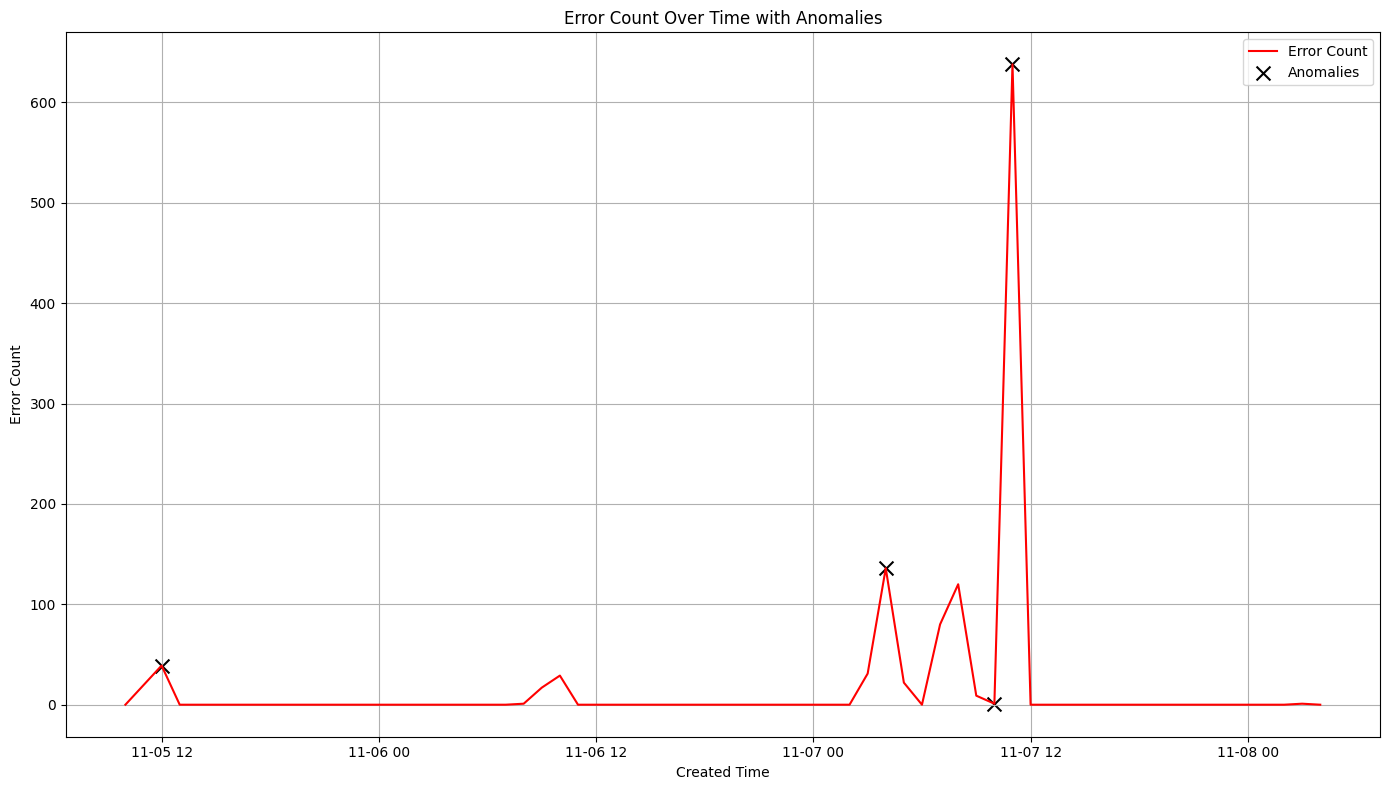

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your DataFrame and 'anomaly_score' indicates anomalies (-1 for anomaly)
plt.figure(figsize=(14, 8))

# Line plot for error count
sns.lineplot(x='createdtime', y='error_count', data=combined_df, label='Error Count', color='red')

# Identify and plot anomalies based on anomaly score
anomalies = combined_df[combined_df['anomaly_score'] == -1]
plt.scatter(anomalies['createdtime'], anomalies['error_count'], color='black', label='Anomalies', marker='x', s=100)  # s=100 increases marker size

# Customize the plot
plt.title("Error Count Over Time with Anomalies")
plt.xlabel("Created Time")
plt.ylabel("Error Count")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

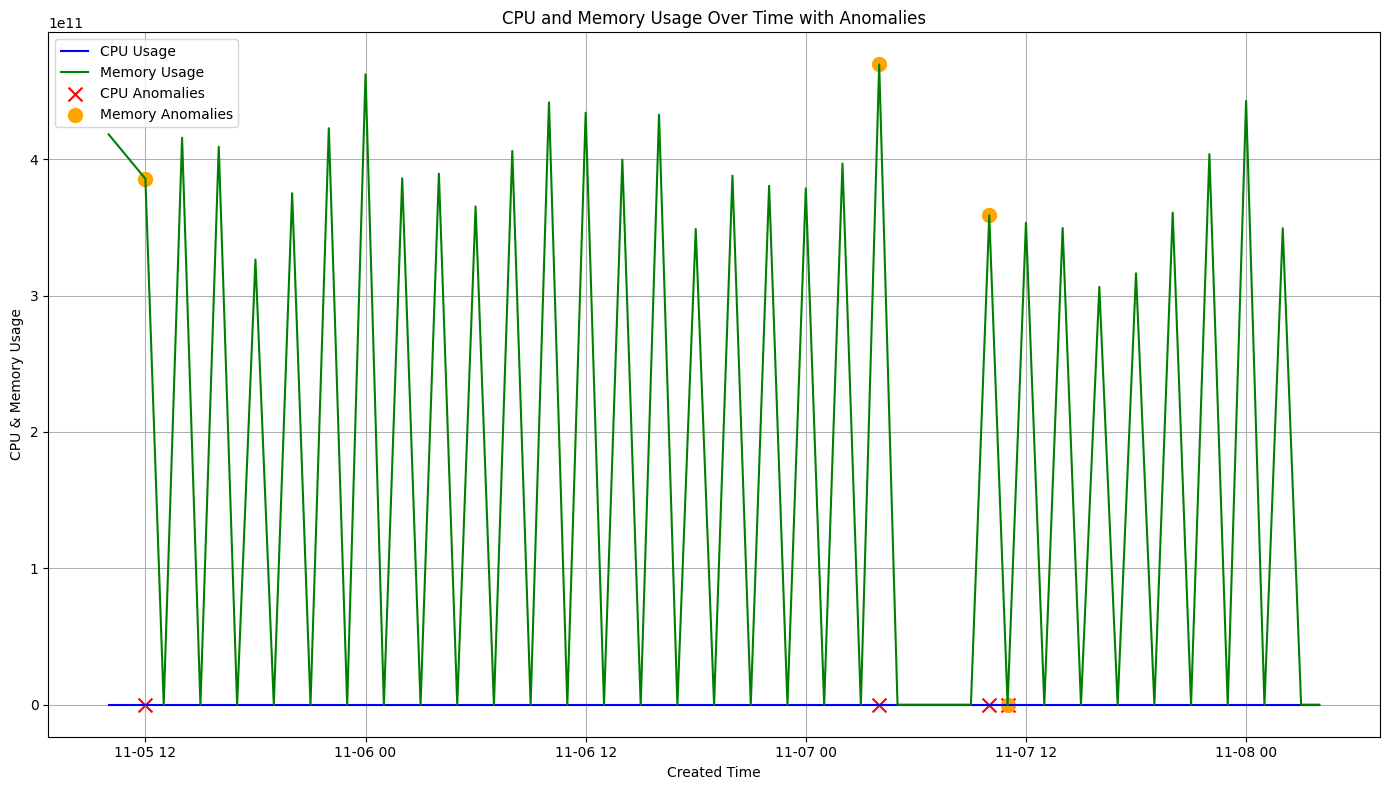

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is your DataFrame and 'anomaly_score' indicates anomalies (-1 for anomaly)
plt.figure(figsize=(14, 8))

# Line plots for CPU and memory usage
sns.lineplot(x='createdtime', y='cpuusage', data=combined_df, label='CPU Usage', color='blue')
sns.lineplot(x='createdtime', y='memoryusage', data=combined_df, label='Memory Usage', color='green')

# Identify and plot anomalies based on anomaly score
anomalies = combined_df[combined_df['anomaly_score'] == -1]
plt.scatter(anomalies['createdtime'], anomalies['cpuusage'], color='red', label='CPU Anomalies', marker='x', s=100)
plt.scatter(anomalies['createdtime'], anomalies['memoryusage'], color='orange', label='Memory Anomalies', marker='o', s=100)  # Use 'o' marker for memory

# Customize the plot
plt.title("CPU and Memory Usage Over Time with Anomalies")
plt.xlabel("Created Time")
plt.ylabel("CPU & Memory Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [17]:
from apscheduler.schedulers.background import BackgroundScheduler
import time

# Scheduler with flexible intervals
def start_scheduler():
    scheduler = BackgroundScheduler()
    scheduler.add_job(query_trino_for_anomalies, 'interval', weeks=1)   # Weekly job
    scheduler.add_job(query_trino_for_anomalies, 'interval', days=1)    # Daily job
    scheduler.add_job(query_trino_for_anomalies, 'interval', hours=24)  # Every 24 hours
  # scheduler.add_job(query_trino_for_anomalies, 'interval', months=1)  # Monthly job
    print("Scheduler started.")
    try:
        scheduler.start()
        while True:
            time.sleep(60)
    except (KeyboardInterrupt, SystemExit):
        scheduler.shutdown()
        print("Scheduler stopped.")

# Start the scheduler
start_scheduler()


Scheduler started.
Scheduler stopped.
